In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('sales_train_v2.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
# Let's add year, month, day, day of week, day of month, week of year
train['date_'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
print(train['date_'].min())
print(train['date_'].max())

2013-01-01 00:00:00
2015-10-31 00:00:00


In [4]:
# Ok, so we need to predict sales for each product of each shop for November 2015.
# Adding features about time of year, week...
# Try to visualize some seasonality?
train['year'] = train['date_'].dt.year
train['month'] = train['date_'].dt.month

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_,year,month
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-02,2013,1
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-03,2013,1
2,05.01.2013,0,25,2552,899.00,-1.0,2013-01-05,2013,1
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-06,2013,1
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-15,2013,1


In [6]:
train_monthly = train[['shop_id', 'item_id', 'year', 'month', 'item_cnt_day']].groupby(['shop_id', 'item_id', 'year', 'month'], as_index=False).sum()
train_monthly.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)
train_monthly.head()

,shop_id,item_id,year,month,item_cnt_month
0,0,30,2013,2,31.0
1,0,31,2013,2,11.0
2,0,32,2013,1,6.0
3,0,32,2013,2,10.0
4,0,33,2013,1,3.0


In [7]:
train_monthly.dtypes
prev_monthly = train_monthly.copy()
prev_monthly['month'] = prev_monthly['month'] + 1
prev_monthly.head()

,shop_id,item_id,year,month,item_cnt_month
0,0,30,2013,3,31.0
1,0,31,2013,3,11.0
2,0,32,2013,2,6.0
3,0,32,2013,3,10.0
4,0,33,2013,2,3.0


In [8]:
# Add previous month item count as a feature
prev_monthly.loc[prev_monthly.month == 13, 'year'] += 1
prev_monthly.loc[prev_monthly.month == 13, 'month'] = 1
prev_monthly.rename(columns={'item_cnt_month': 'previous_month_cnt'}, inplace=True)
prev_monthly.head()

,shop_id,item_id,year,month,previous_month_cnt
0,0,30,2013,3,31.0
1,0,31,2013,3,11.0
2,0,32,2013,2,6.0
3,0,32,2013,3,10.0
4,0,33,2013,2,3.0


In [9]:
train_monthly = train_monthly.merge(prev_monthly, on=['shop_id', 'item_id', 'year', 'month'], how='left')
train_monthly.head()

,shop_id,item_id,year,month,item_cnt_month,previous_month_cnt
0,0,30,2013,2,31.0,NaN
1,0,31,2013,2,11.0,NaN
2,0,32,2013,1,6.0,NaN
3,0,32,2013,2,10.0,6.0
4,0,33,2013,1,3.0,NaN


In [10]:
train_monthly['previous_month_cnt'] = train_monthly['previous_month_cnt'].fillna(0)
train_monthly.head()

,shop_id,item_id,year,month,item_cnt_month,previous_month_cnt
0,0,30,2013,2,31.0,0.0
1,0,31,2013,2,11.0,0.0
2,0,32,2013,1,6.0,0.0
3,0,32,2013,2,10.0,6.0
4,0,33,2013,1,3.0,0.0


In [11]:
# Add mean item price from previous month as feature
mean_price = train[['shop_id', 'item_id', 'year', 'month', 'item_price']].groupby(['shop_id', 'item_id', 'year', 'month'], as_index=False).mean()
mean_price.loc[mean_price.month == 13, 'year'] += 1
mean_price.loc[mean_price.month == 13, 'month'] = 1
mean_price.rename(columns={'item_price': 'prev_mean_item_price'}, inplace=True)

In [12]:
train_monthly = train_monthly.merge(mean_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
train_monthly.head()

,shop_id,item_id,year,month,item_cnt_month,previous_month_cnt,prev_mean_item_price
0,0,30,2013,2,31.0,0.0,265.0
1,0,31,2013,2,11.0,0.0,434.0
2,0,32,2013,1,6.0,0.0,221.0
3,0,32,2013,2,10.0,6.0,221.0
4,0,33,2013,1,3.0,0.0,347.0


In [13]:
train_monthly['prev_mean_item_price'] = train_monthly['prev_mean_item_price'].fillna(0)

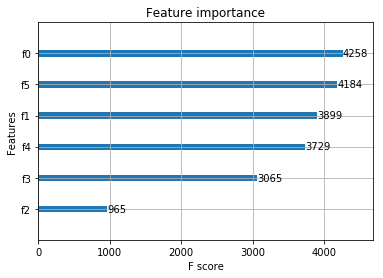

In [ ]:
# Exploring features importance
import xgboost as xgb
dtrain = xgb.DMatrix(train_monthly.drop(['item_cnt_month'], axis=1).values, train_monthly[['item_cnt_month']].values)
param = {'max_depth':10, 'eta':0.05, 'silent':0, 'objective':'reg:linear' }
num_round = 50
xgb_feat = xgb.train(param, dtrain, num_round)
xgb.plot_importance(xgb_feat)

In [ ]:
reg_model = xgb.XGBRegressor(learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, n_jobs=-1)
reg_model.fit(train_monthly.drop(['item_cnt_month'], axis=1), train_monthly[['item_cnt_month']])

In [ ]:
test_set = pd.read_csv('test.csv')
test_set['year'] = pd.Series(2015, index=test_set.index)
test_set['month'] = pd.Series(11, index=test_set.index)
test_set = test_set.merge(prev_monthly, on=['shop_id', 'item_id', 'year', 'month'], how='left')
test_set['previous_month_cnt'] = test_set['previous_month_cnt'].fillna(0)
test_set = test_set.merge(mean_price, on=['shop_id', 'item_id', 'year', 'month'], how='left')
test_set['prev_mean_item_price'] = test_set['prev_mean_item_price'].fillna(0)

# Fill NA?
test_set.head()

In [ ]:
xgb_preds = reg_model.predict(test_set.drop('ID', axis=1))

In [ ]:
test_set['item_cnt_month'] = pd.Series(xgb_preds)
prev_sales_preds = test_set[['ID', 'item_cnt_month']]
prev_sales_preds['item_cnt_month'] = prev_sales_preds['item_cnt_month'].clip(0, 20)
prev_sales_preds.to_csv('previous_xgb.csv', index=False)